In [75]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
path = "/Users/martin/Library/CloudStorage/GoogleDrive-fleischma@natur.cuni.cz/Shared drives/US CUNI/Data/2024_building_footprints/OSM_no_overlap_collapse.parquet"

In [80]:
blgs = gpd.read_parquet(path)

Ensure we deal only with polygons.

In [82]:
blgs = blgs.explode(ignore_index=True)
blgs = blgs[blgs.geom_type == "Polygon"]

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  return gf.set_geometry(col, drop=drop, inplace=False, crs=crs)


Define the functions

In [85]:
def _snap(geometry, reference, threshold, segment_length):
    """Snap g1 to g2 within threshold

    Parameters
    ----------
    geometry : shapely.Polygon
        geometry to snap
    reference : shapely.Polygon
        geometry to snap to
    threshold : float
        max distance between vertices to snap
    segment_length : float
        max segment length parameter in segmentize

    Returns
    -------
    shapely.Polygon
        snapped geometry
    """
    import shapely

    # extract the shell and holes from the first geometry
    shell, holes = geometry.exterior, geometry.interiors
    # segmentize the shell and extract coordinates
    coords = shapely.get_coordinates(shapely.segmentize(shell, segment_length))
    # create a point geometry from the coordinates
    points = shapely.points(coords)
    # find the shortest line between the points and the second geometry
    lines = shapely.shortest_line(points, reference)
    # mask the coordinates where the distance is less than the threshold
    distance_mask = shapely.length(lines) < threshold

    # return the original geometry if no coordinates are within the threshold
    if not any(distance_mask):
        return geometry

    # update the coordinates with the snapped coordinates
    coords[distance_mask] = shapely.get_coordinates(lines)[1::2][distance_mask]
    # re-create the polygon with new coordinates and original holes and simplify
    # to remove any extra vertices
    return shapely.simplify(shapely.Polygon(coords, holes=holes), segment_length / 100)


def snap(geometry, threshold=0.5):
    """Snap geometries that are within threshold to each other

    Only one of the pair of geometries identified as nearby will be snapped. Most likely
    the one with the lower index.

    Parameters
    ----------
    geometry : GeoDataFrame | GeoSeries
        geometries to snap. Geometry type needs to be Polygon for all of them.
    threshold : float, optional
        max distance between geometries to snap, by default 0.5

    Returns
    -------
    GeoSeries
        GeoSeries with snapped geometries
    """
    nearby_a, nearby_b = geometry.sindex.query(
        geometry.geometry, predicate="dwithin", distance=threshold
    )
    overlap_a, overlap_b = geometry.boundary.sindex.query(
        geometry.boundary, predicate="overlaps"
    )

    self_mask = nearby_a != nearby_b
    nearby_a = nearby_a[self_mask]
    nearby_b = nearby_b[self_mask]

    self_mask = overlap_a != overlap_b
    overlap_a = overlap_a[self_mask]
    overlap_b = overlap_b[self_mask]

    nearby = pd.MultiIndex.from_arrays([nearby_a, nearby_b], names=("source", "target"))
    overlap = pd.MultiIndex.from_arrays(
        [overlap_a, overlap_b], names=("source", "target")
    )
    nearby_not_overlap = nearby.difference(overlap)
    duplicated = pd.DataFrame(
        np.sort(np.array(nearby_not_overlap.to_list()), axis=1)
    ).duplicated()
    pairs_to_snap = nearby_not_overlap[~duplicated]

    new_geoms = []
    for geom, ref in zip(
        geometry.geometry.iloc[pairs_to_snap.get_level_values("source")],
        geometry.geometry.iloc[pairs_to_snap.get_level_values("target")],
    ):
        new_geoms.append(
            _snap(geom, ref, threshold=threshold, segment_length=threshold)
        )

    snapped = geometry.geometry.copy()
    snapped.iloc[pairs_to_snap.get_level_values("source")] = new_geoms
    return snapped

Get snapped geometry.

In [86]:
fixed = snap(blgs, threshold=0.5)

  0%|          | 0/25108 [00:00<?, ?it/s]

Verify

<Axes: >

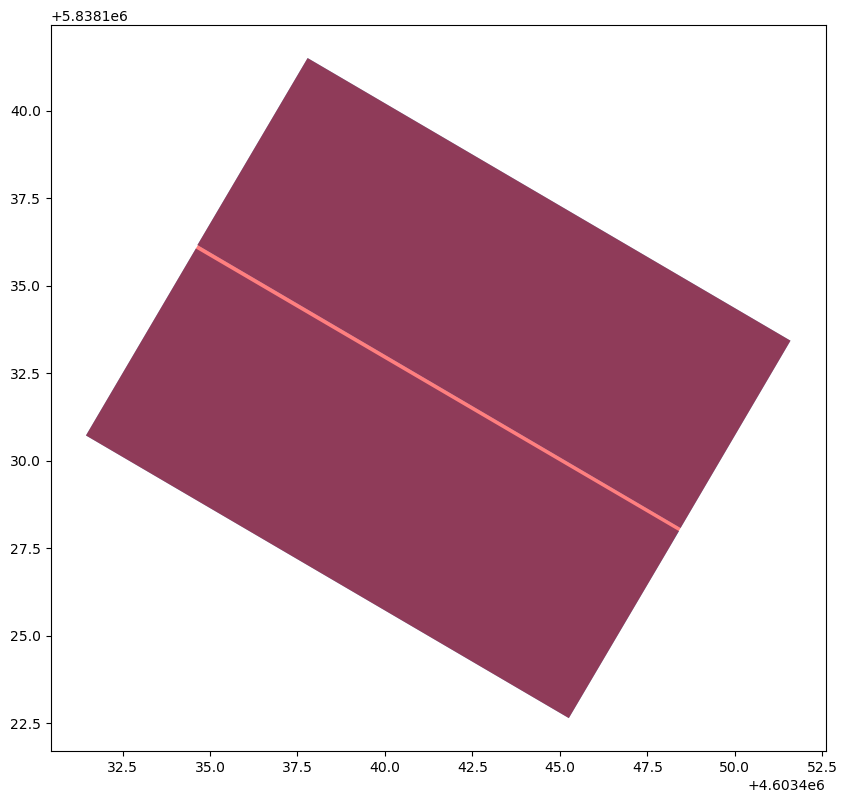

In [113]:
ax = blgs.iloc[[1056191, 1056192]].plot(figsize=(10, 10))
fixed.iloc[[1056191, 1056192]].plot(ax=ax, color="red", alpha=0.5)